In [ ]:
import ee
import os
import json
import numpy as np
import pandas as pd
import geopandas as gpd

from shapely.geometry import shape, Point, Polygon, MultiPolygon
from shapely.ops import unary_union
from matplotlib import pyplot as plt

In [ ]:
###  census subdivision of Saint John
os.chdir(f"/content/drive/MyDrive/TEMPO/Statistics Canada/Shapefiles")
csd_shp = gpd.read_file(f"./Subdivision/lcsd000b21a_e.shp")
csd_sj = csd_shp[csd_shp["CSDNAME"] == "Saint John"]
csd_sj_geom_gjs = gpd.GeoDataFrame(csd_sj[["geometry"]])
csd_sj_geom_gjs = csd_sj_geom_gjs.set_crs(epsg=3347)
csd_sj_geom_gjs = csd_sj_geom_gjs.to_crs(epsg=4326)

In [ ]:
region = ee.Geometry.Rectangle([np.min(csd_sj_geom_gjs.bounds.minx),
                                np.min(csd_sj_geom_gjs.bounds.miny),
                                np.max(csd_sj_geom_gjs.bounds.maxx),
                                np.max(csd_sj_geom_gjs.bounds.maxy)])

<Axes: >

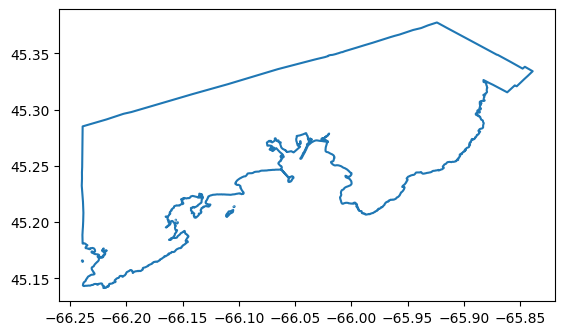

In [ ]:
##  union
gpd.GeoSeries([csd_sj_geom_gjs]).boundary.plot()

In [ ]:
###  1)  DayMet

feature_layers = ['dayl','prcp','srad','tmax','tmin','vp']

for f in feature_layers:

    daymet_collection = ee.ImageCollection('NASA/ORNL/DAYMET_V4') \
              .filterDate('2022-01-01', '2024-01-01') \
              .filterBounds(region) \
              .select(f)

    ##  clipping collection to the CMA boundary
    daymet_collection_non_null = daymet_collection.map(
        lambda image: image_perc_mask(image, 1000, region)).filter(ee.Filter.gt('percCover', 0)
    )

    ## processing
    daymet_collection_array = daymet_collection.getRegion(geometry = region, scale = 1000)
    feature_names = daymet_collection_array.get(0)
    get_export = ee.FeatureCollection(daymet_collection_array.map(lambda image: create_export(image, feature_names)))

    ## exporting
    tasks = ee.batch.Export.table.toDrive(**{
            'collection': get_export,
            'description': "Saint John DAYMET_2023-01-01_2023-12-31_" + f,
            'folder': "Spatial Time Series",
            'fileFormat':'CSV',
            'selectors': ['id', 'longitude', 'latitude', 'time', f]
    })
    tasks.start()

    complete = 0
    while complete == 0:
        if tasks.status()['state'] == 'COMPLETED':
            complete = 1
        else:
            complete = 0
    print("Completed " + f + ".")

Completed dayl.
Completed prcp.
Completed srad.
Completed tmax.
Completed tmin.
Completed vp.


In [ ]:
###  2)  GOES-16

date_range = pd.date_range('2022-01-01', '2024-01-01')

d_avg = []

for d in range(len(date_range) - 1):

    startdate = str(date_range[d]).split(" ")[0]
    enddate = str(date_range[d+1]).split(" ")[0]

    goes16_abi_daily_extract = ee.ImageCollection('NOAA/GOES/16/MCMIPC') \
              .filterDate(startdate, enddate) \
              .select(['CMI_C01', 'CMI_C02', 'CMI_C03','CMI_C08', 'CMI_C09', 'CMI_C10','CMI_C11','CMI_C12']) \
              .filterBounds(region) \
              .reduce(ee.Reducer.mean()) \
              .set({'Start_Date': startdate,
                    'End_Date': enddate})

    d_avg.append(goes16_abi_daily_extract)

goes16_abi_daily_collection = ee.ImageCollection.fromImages(d_avg)

feature_layers = ['CMI_C01_mean', 'CMI_C02_mean', 'CMI_C03_mean', 'CMI_C08_mean', 'CMI_C09_mean', 'CMI_C10_mean', 'CMI_C11_mean', 'CMI_C12_mean']

for f in feature_layers:

    ## get data for each grid point
    goes16_abi_collection = goes16_abi_daily_collection.filterBounds(region).select(f)
    ##  clipping collection to the CMA boundary
    goes16_abi_collection_non_null = goes16_abi_collection.map(
        lambda image: image_perc_mask(image, 2000, region)).filter(ee.Filter.gt('percCover', 0)
    )

    ## processing
    goes16_abi_collection_array = goes16_abi_collection_non_null.getRegion(geometry = region, scale = 2000)
    feature_names = goes16_abi_collection_array.get(0)
    get_export = ee.FeatureCollection(goes16_abi_collection_array.map(lambda image: create_export(image, feature_names)))

    ## exporting
    tasks = ee.batch.Export.table.toDrive(**{
            'collection': get_export,
            'description': "Saint John ABI_2021-12-01_2022-01-01_" + f,
            'folder': "Spatial Time Series",
            'fileFormat':'CSV',
            'selectors': ['id', 'longitude', 'latitude', 'time', 'Start_Date', 'End_Date', f]
    })
    tasks.start()

    complete = 0
    while complete == 0:
        if tasks.status()['state'] == 'COMPLETED':
            complete = 1
        else:
            complete = 0
    print("Completed " + f + ".")

Completed CMI_C01_mean.
Completed CMI_C02_mean.
Completed CMI_C03_mean.
Completed CMI_C08_mean.
Completed CMI_C09_mean.
Completed CMI_C10_mean.
Completed CMI_C11_mean.
Completed CMI_C12_mean.


In [ ]:
###  3.1)  TROPOMI SO2

date_range = pd.date_range('2022-01-01', '2024-01-01')

d_avg = []

for d in range(len(date_range) - 1):

    startdate = str(date_range[d]).split(" ")[0]
    enddate = str(date_range[d+1]).split(" ")[0]

    tropomi_so2_daily_extract = ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_SO2') \
              .filterDate(startdate, enddate) \
              .select(['SO2_column_number_density_15km', 'SO2_column_number_density', 'absorbing_aerosol_index', 'cloud_fraction']) \
              .filterBounds(region) \
              .reduce(ee.Reducer.mean()) \
              .set({'Start_Date': startdate,
                    'End_Date': enddate})

    d_avg.append(tropomi_so2_daily_extract)

tropomi_so2_daily_collection = ee.ImageCollection.fromImages(d_avg)

feature_layers = ['SO2_column_number_density_15km_mean', 'SO2_column_number_density_mean', 'absorbing_aerosol_index_mean', 'cloud_fraction_mean']

for f in feature_layers:

    ## get data for each grid point
    tropomi_so2_collection = tropomi_so2_daily_collection.filterBounds(region).select(f)
    ##  clipping collection to the CMA boundary
    tropomi_so2_collection_non_null = tropomi_so2_collection.map(
        lambda image: image_perc_mask(image, 1113, region)).filter(ee.Filter.gt('percCover', 0)
    )

    ## processing
    tropomi_so2_collection_array = tropomi_so2_collection_non_null.getRegion(geometry = region, scale = 1113)
    feature_names = tropomi_so2_collection_array.get(0)
    get_export = ee.FeatureCollection(tropomi_so2_collection_array.map(lambda image: create_export(image, feature_names)))

    ## exporting
    tasks = ee.batch.Export.table.toDrive(**{
            'collection': get_export,
            'description': "Saint John TROPOMI_2022-01-01_2022-12-31_" + f,
            'folder': "Spatial Time Series",
            'fileFormat':'CSV',
            'selectors': ['id', 'longitude', 'latitude', 'time', 'Start_Date', 'End_Date', f]
    })
    tasks.start()

    complete = 0
    while complete == 0:
        if tasks.status()['state'] == 'COMPLETED':
            complete = 1
        else:
            complete = 0
    print("Completed " + f + ".")

Completed SO2_column_number_density_15km_mean.
Completed SO2_column_number_density_mean.
Completed absorbing_aerosol_index_mean.
Completed cloud_fraction_mean.


In [ ]:
###  3.2)  TROPOMI Clouds

date_range = pd.date_range('2022-01-01', '2024-01-01')

d_avg = []

for d in range(len(date_range) - 1):

    startdate = str(date_range[d]).split(" ")[0]
    enddate = str(date_range[d+1]).split(" ")[0]

    tropomi_so2_daily_extract = ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_CLOUD') \
              .filterDate(startdate, enddate) \
              .select(['cloud_top_height', 'cloud_base_height', 'cloud_top_pressure', 'cloud_base_pressure', 'surface_albedo']) \
              .filterBounds(region) \
              .reduce(ee.Reducer.mean()) \
              .set({'Start_Date': startdate,
                    'End_Date': enddate})

    d_avg.append(tropomi_so2_daily_extract)

tropomi_so2_daily_collection = ee.ImageCollection.fromImages(d_avg)

feature_layers = ['cloud_top_height_mean', 'cloud_base_height_mean', 'cloud_top_pressure_mean', 'cloud_base_pressure_mean', 'surface_albedo_mean']

for f in feature_layers:

    ## get data for each grid point
    tropomi_so2_collection = tropomi_so2_daily_collection.filterBounds(region).select(f)
    ##  clipping collection to the CMA boundary
    tropomi_so2_collection_non_null = tropomi_so2_collection.map(
        lambda image: image_perc_mask(image, 1113, region)).filter(ee.Filter.gt('percCover', 0)
    )

    ## processing
    tropomi_so2_collection_array = tropomi_so2_collection_non_null.getRegion(geometry = region, scale = 1113)
    feature_names = tropomi_so2_collection_array.get(0)
    get_export = ee.FeatureCollection(tropomi_so2_collection_array.map(lambda image: create_export(image, feature_names)))

    ## exporting
    tasks = ee.batch.Export.table.toDrive(**{
            'collection': get_export,
            'description': "Saint John TROPOMI_Cloud_2022-01-01_2022-12-31_" + f,
            'folder': "Spatial Time Series",
            'fileFormat':'CSV',
            'selectors': ['id', 'longitude', 'latitude', 'time', 'Start_Date', 'End_Date', f]
    })
    tasks.start()

    complete = 0
    while complete == 0:
        if tasks.status()['state'] == 'COMPLETED':
            complete = 1
        else:
            complete = 0
    print("Completed " + f + ".")

Completed cloud_top_height_mean.
Completed cloud_base_height_mean.
Completed cloud_top_pressure_mean.
Completed cloud_base_pressure_mean.
Completed surface_albedo_mean.


In [ ]:
###  4)  Real-Time Mesoscale Analysis

date_range = pd.date_range('2022-01-01', '2024-01-01')

d_avg = []

for d in range(len(date_range) - 1):

    startdate = str(date_range[d]).split(" ")[0]
    enddate = str(date_range[d+1]).split(" ")[0]

    rtma_winds_daily_extract = ee.ImageCollection('NOAA/NWS/RTMA') \
              .filterDate(startdate, enddate) \
              .select(['UGRD', 'VGRD', 'WDIR', 'WIND', 'GUST', 'VIS']) \
              .filterBounds(region) \
              .reduce(ee.Reducer.mean()) \
              .set({'Start_Date': startdate,
                    'End_Date': enddate})

    d_avg.append(rtma_winds_daily_extract)

rtma_winds_daily_collection = ee.ImageCollection.fromImages(d_avg)

feature_layers = [x + "_mean" for x in ['UGRD', 'VGRD', 'WDIR', 'WIND', 'GUST', 'VIS']]

for f in feature_layers:

    ## get data for each grid point
    rtma_winds_collection = rtma_winds_daily_collection.filterBounds(region).select(f)
    ##  clipping collection to the CMA boundary
    rtma_winds_collection_non_null = rtma_winds_collection.map(
        lambda image: image_perc_mask(image, 1113, region)).filter(ee.Filter.gt('percCover', 0)
    )

    ## processing
    rtma_winds_collection_array = rtma_winds_collection_non_null.getRegion(geometry = region, scale = 2500)
    feature_names = rtma_winds_collection_array.get(0)
    get_export = ee.FeatureCollection(rtma_winds_collection_array.map(lambda image: create_export(image, feature_names)))

    ## exporting
    tasks = ee.batch.Export.table.toDrive(**{
            'collection': get_export,
            'description': "Saint John RTMA_2023-01-01_2023-12-31_" + f,
            'folder': "Spatial Time Series",
            'fileFormat':'CSV',
            'selectors': ['id', 'longitude', 'latitude', 'time', 'Start_Date', 'End_Date', f]
    })
    tasks.start()

    complete = 0
    while complete == 0:
        if tasks.status()['state'] == 'COMPLETED':
            complete = 1
        else:
            complete = 0
    print("Completed " + f + ".")

Completed UGRD_mean.
Completed VGRD_mean.
Completed WDIR_mean.
Completed WIND_mean.
Completed GUST_mean.
Completed VIS_mean.


In [ ]:
landcover_collection = ee.ImageCollection('MODIS/061/MCD12Q1') \
                        .filterDate("2022-01-01", "2023-01-01") \
                        .map(lambda x: x.clip(region)) \
                        .select(["LC_Type4"])

landcover = landcover_collection.toList(landcover_collection.size())
landcover = ee.Image(landcover.get(0))

tasks = ee.batch.Export.image.toDrive(**{
        'image': landcover,
        'description': "Saint John Modis_LandCover",
        'folder': "Code Resources",
        'region': region,
        'scale': 500,
        'fileFormat':'GeoTIFF',
        'crs':'EPSG:4326'
})
tasks.start()

In [ ]:
dem = ee.Image('USGS/SRTMGL1_003') \
        .select("elevation")

tasks = ee.batch.Export.image.toDrive(**{
        'image': dem,
        'description': "SJ_DEM",
        'folder': 'Code Resources',
        'region': region,
        'scale': 30,
        'crs':'EPSG:4326',
        'fileFormat':'GeoTIFF',
    })
tasks.start()

In [ ]:
built_height = ee.Image('JRC/GHSL/P2023A/GHS_BUILT_H/2018') \
                .select("built_height")

tasks = ee.batch.Export.image.toDrive(**{
        'image': built_height,
        'description': "SJ_built_height",
        'folder': 'Code Resources',
        'region': region,
        'scale': 100,
        'crs':'EPSG:4326',
        'fileFormat':'GeoTIFF',
    })
tasks.start()

In [ ]:
pop_density = ee.Image('JRC/GHSL/P2023A/GHS_POP/2020') \
                .select("population_count")

tasks = ee.batch.Export.image.toDrive(**{
        'image': pop_density,
        'description': "SJ_pop_density",
        'folder': 'Code Resources',
        'region': region,
        'scale': 100,
        'crs':'EPSG:4326',
        'fileFormat':'GeoTIFF',
    })
tasks.start()

In [ ]:
###  250-m grids
width = np.array((csd_sj_geom_gjs.bounds.maxx - csd_sj_geom_gjs.bounds.minx) / 0.0025)[0]
height = np.array((csd_sj_geom_gjs.bounds.maxy - csd_sj_geom_gjs.bounds.miny) / 0.0025)[0]

print((width, height))

(160.29312912363594, 94.39160587098456)


In [ ]:
###  500-m grids
width = np.array((csd_sj_geom_gjs.bounds.maxx - csd_sj_geom_gjs.bounds.minx) / 0.005)[0]
height = np.array((csd_sj_geom_gjs.bounds.maxy - csd_sj_geom_gjs.bounds.miny) / 0.005)[0]

print((width, height))

(80.14656456181797, 47.19580293549228)


In [ ]:
##  consider there are two grid-line edges per each dimension
dim = (75+2, 45+2)

##  starting from northend and westend
top_left_corner_h = np.array([csd_sj_geom_gjs.bounds.minx + 0.005 * z for z in range(dim[0])]).reshape(-1).tolist()
top_right_corner_h = top_left_corner_h[1:] + [top_left_corner_h[-1] + 0.005]
top_left_corner_v = np.array([csd_sj_geom_gjs.bounds.maxy - 0.005 * z for z in range(dim[1])]).reshape(-1).tolist()
bottom_left_corner_v = top_left_corner_v[1:] + [top_left_corner_v[-1] - 0.005]

centroids_h = top_left_corner_h + [top_right_corner_h[-1]]
centroids_v = top_left_corner_v + [bottom_left_corner_v[-1]]
centroids_h = [0.5 * (centroids_h[x] + centroids_h[x+1]) for x in range(len(centroids_h) - 1)]
centroids_v = [0.5 * (centroids_v[x] + centroids_v[x+1]) for x in range(len(centroids_v) - 1)]

In [ ]:
print(len(centroids_h))
print(len(centroids_v))

77
47


In [ ]:
print(centroids_h)
print(centroids_v)

[-66.23706457907666, -66.23206457907665, -66.22706457907665, -66.22206457907666, -66.21706457907666, -66.21206457907665, -66.20706457907666, -66.20206457907665, -66.19706457907665, -66.19206457907666, -66.18706457907666, -66.18206457907665, -66.17706457907666, -66.17206457907666, -66.16706457907665, -66.16206457907666, -66.15706457907666, -66.15206457907667, -66.14706457907666, -66.14206457907666, -66.13706457907665, -66.13206457907665, -66.12706457907666, -66.12206457907666, -66.11706457907665, -66.11206457907666, -66.10706457907665, -66.10206457907665, -66.09706457907666, -66.09206457907666, -66.08706457907665, -66.08206457907666, -66.07706457907665, -66.07206457907665, -66.06706457907666, -66.06206457907666, -66.05706457907665, -66.05206457907666, -66.04706457907666, -66.04206457907665, -66.03706457907666, -66.03206457907666, -66.02706457907667, -66.02206457907666, -66.01706457907666, -66.01206457907665, -66.00706457907665, -66.00206457907666, -65.99706457907666, -65.99206457907665,

In [ ]:
coords = [
    centroids_h,
    centroids_v
]

In [ ]:
with open(f'/content/drive/MyDrive/reference_grids.json', 'w') as f:
    json.dump(coords, f)

In [ ]:
polys_coords = list()
polys_ids = list()

for i in range(77):
    for j in range(47):
        polys_coords.append(
            Polygon([[top_left_corner_h[i], top_left_corner_v[j]],
                     [top_right_corner_h[i], top_left_corner_v[j]],
                     [top_right_corner_h[i], bottom_left_corner_v[j]],
                     [top_left_corner_h[i], bottom_left_corner_v[j]],
                     [top_left_corner_h[i], top_left_corner_v[j]],
                    ])
        )
        polys_ids.append(str(i) + "_" + str(j))

grids_coords = gpd.GeoDataFrame({
    "id": polys_ids,
    "geometry": polys_coords
})

In [ ]:
grids_coords.to_file(f'/content/drive/MyDrive/reference_grids.shp')

In [ ]:
grids_coords

,id,geometry
0,0_0,"POLYGON ((-66.23956 45.37748, -66.23456 45.377..."
1,0_1,"POLYGON ((-66.23956 45.37248, -66.23456 45.372..."
2,0_2,"POLYGON ((-66.23956 45.36748, -66.23456 45.367..."
3,0_3,"POLYGON ((-66.23956 45.36248, -66.23456 45.362..."
4,0_4,"POLYGON ((-66.23956 45.35748, -66.23456 45.357..."
...,...,...
3614,76_42,"POLYGON ((-65.85956 45.16748, -65.85456 45.167..."
3615,76_43,"POLYGON ((-65.85956 45.16248, -65.85456 45.162..."
3616,76_44,"POLYGON ((-65.85956 45.15748, -65.85456 45.157..."
3617,76_45,"POLYGON ((-65.85956 45.15248, -65.85456 45.152..."
